In [30]:
from tools.project import INPUT_PATH, LOGS_PATH, OUTPUT_PATH, MODELS_PATH, RAW_PATH
import torch
import os
from datasets import Audio, load_dataset, Dataset
from src.jamendo_utils import read_file
from audiocraft.utils.notebook import display_audio
import numpy as np
import pandas as pd
from transformers import ClapConfig, ClapModel, AutoFeatureExtractor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import default_collate
import tqdm
import json
from audiocraft.data.audio import audio_read, audio_write
from audiocraft.data.audio_utils import convert_audio_channels, convert_audio


import umap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from collections import Counter
from audiocraft.models import MusicGen
import uuid
from dotenv import load_dotenv
import random

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:
model = ClapModel.from_pretrained("laion/clap-htsat-unfused").to(DEVICE)
feature_extractor = AutoFeatureExtractor.from_pretrained("laion/clap-htsat-unfused")

/home/mszawerda/.cache/pypoetry/virtualenvs/musicgen-ufgTm-Qc-py3.10/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [79]:
ds=load_dataset('csv', data_files=[
                RAW_PATH('song_describer', 'song_describer.csv'),
                ], split='train')
captions = {}
for row in ds:
    idx = row['track_id']
    captions[idx] = captions.get(idx, [])
    captions[idx].append(row['caption'])

In [77]:
base_dir = RAW_PATH('song_describer', 'audio')

def map_path(ex):
    ex['audio'] = os.path.join(base_dir, ex['path'].replace('.mp3', '.2min.mp3'))
    return ex
def show_audio(ds, sec=10):
    for song in ds['audio']:
        display_audio(torch.Tensor(np.array(song['array']))[:song['sampling_rate']*sec][None], song['sampling_rate'])

ds=load_dataset('csv', data_files=[
                RAW_PATH('song_describer', 'song_describer.csv'),
                ], split='train').map(map_path)
ds = Dataset.from_pandas(ds.to_pandas().drop_duplicates(['track_id']))
tracks, tags, extra = read_file(RAW_PATH('song_describer', 'song_describer_14_04_23.mtg-jamendo.tsv'))
pop_artists = pd.Series([x['artist_id'] for k, x in tracks.items()]).value_counts().nlargest(5).index.tolist()
pop_artists

Reading: 705 tracks, 359 albums, 191 artists


[7063, 7805, 343767, 338649, 432273]

In [47]:
sr=44100
pop_artis = pop_artists[1]
theme_filter = lambda x: x['track_id'] in tags['mood/theme']['relaxing']
pop_filter = lambda x: x['artist_id'] == pop_artis
ds_filtered = ds.cast_column('audio', Audio(sampling_rate=48000))
show_audio(ds_filtered.take(3))

In [5]:
embeds = []
ids = []
with torch.no_grad():
    for row in tqdm.tqdm(ds_filtered):
        audio = row['audio']
        inputs = feature_extractor(torch.tensor(audio['array']), return_tensors="pt", sampling_rate=audio['sampling_rate'])
        ids.append(row['track_id'])
        embeds.append(model.get_audio_features(**inputs, ))
    
dim_input = torch.stack(embeds).squeeze().cpu().numpy()
reducer = umap.UMAP(n_neighbors=5, n_components=2, metric='cosine')
# reducer = PCA(n_components=2)

embeddings_2d = reducer.fit_transform(dim_input)

100%|██████████| 706/706 [05:06<00:00,  2.30it/s]
/home/mszawerda/.cache/pypoetry/virtualenvs/musicgen-ufgTm-Qc-py3.10/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Map:   0%|          | 0/706 [00:00<?, ? examples/s]

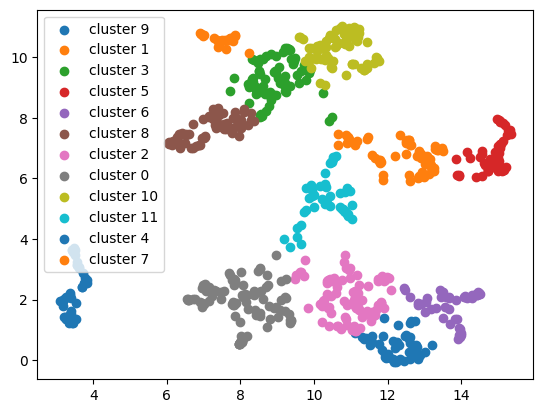

In [9]:
n_clusters = 12
clst = KMeans(n_clusters=n_clusters, random_state=0)
# clst = DBSCAN(eps=0.06, min_samples=5)

labels = clst.fit_predict(embeddings_2d)
clusters = {}
rev_lab = {}
for idx, label in enumerate(labels):
    rev_lab[ids[idx]] = idx
    if label not in clusters:
        clusters[label] = set()
    clusters[label].add(ids[idx])
ds_filtered=ds_filtered.map(lambda x, idx: {'clst': labels[idx]}, with_indices=True)

for i, idxs in clusters.items():
    a_id = [rev_lab[x] for x in idxs]
    plt.scatter(embeddings_2d[a_id, 0], embeddings_2d[a_id, 1], label=f'cluster {i}')
plt.legend()

In [ ]:
cl_ids = set(clusters[10])
id_filter = lambda x: x['track_id'] in cl_ids

show_audio(ds_filtered.filter(id_filter, num_proc=12).take(5))

In [11]:
ds_filtered.remove_columns(['audio']).to_json(RAW_PATH('song_describer', 'clap_clustered.json'))

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

221328

In [80]:
df=pd.read_json(RAW_PATH('song_describer', 'clap_clustered.jsonl'), lines=True)[['track_id', 'clst']]
df['genre']=df.apply(lambda x: tracks.get(x['track_id'], {}).get('genre', set()), axis=1)
df['instrument']=df.apply(lambda x: tracks.get(x['track_id'], {}).get('instrument', set()), axis=1)
df['mood/theme']=df.apply(lambda x: tracks.get(x['track_id'], {}).get('mood/theme', set()), axis=1)
df['path']=df.apply(lambda x: tracks.get(x['track_id'], {}).get('path', "").replace('.mp3', '.2min.mp3'), axis=1)
df['descriptions']=df.apply(lambda x: captions.get(x['track_id'], []), axis=1)
df['text_clst']=df.apply(lambda x: text_clustered.get(x['track_id'], []), axis=1)
df.to_json(RAW_PATH('ds-indexes', 'song-describer.jsonl'), lines=True, orient="records", force_ascii=False)
df

,track_id,clst,genre,instrument,mood/theme,path,descriptions,text_clst
0,1004034,9,"{progressive, electronic, house, trance}",{},{},34/1004034.2min.mp3,[Electronic music that has a constant melody t...,[0]
1,1007274,1,{easylistening},{},{},74/1007274.2min.mp3,[acoustic guitar solo track with consistent rh...,[2]
2,1009671,3,"{electronic, pop, rock, popfolk}","{drum, piano, synthesizer, acousticguitar}","{commercial, entertainment}",71/1009671.2min.mp3,"[A rock song with a country vibe, it has male ...","[6, 1, 1, 7]"
3,1009672,3,"{electronic, pop}","{bass, drum, piano, synthesizer}","{commercial, fashion, entertainment}",72/1009672.2min.mp3,[A joyful and lively song that will make you w...,"[1, 7, 7]"
4,1009673,5,"{popfolk, pop, folk}","{drum, piano, synthesizer, acousticguitar}","{communication, commercial, entertainment}",73/1009673.2min.mp3,[Upbeat song that has a humming riff accompani...,"[7, 6, 7]"
...,...,...,...,...,...,...,...,...
701,976784,9,"{electronic, jazz, lounge}","{electricpiano, violin, synthesizer}",{relaxing},84/976784.2min.mp3,[upbeat electronic music with occasional melod...,[4]
702,976785,9,"{electronic, jazz, lounge}","{electricpiano, violin, synthesizer}",{relaxing},85/976785.2min.mp3,[Techno-house track that lopes and has synthet...,[4]
703,981782,5,"{popfolk, pop, folk}",{bells},"{happy, christmas}",82/981782.2min.mp3,[Sweet French song performed by a soft male vo...,[5]
704,986583,5,"{folk, popfolk, chanson}",{},{},83/986583.2min.mp3,[A poetic song by a French male singer-songwri...,[5]


In [5]:
grouped_counts = {}
clusters = {}

for cluster, group in df.groupby('clst'):
    def col(col_name):
        flattened_values = [item for subset in group[col_name] for item in subset]
        value_counts = Counter(flattened_values)
        return dict(sorted(value_counts.items(), key=lambda item: item[1], reverse=True)[:5])
    grouped_counts[cluster] = {
        'genre': col('genre'),
        'instrument': col('instrument'),
        'mood/theme': col('mood/theme')
    }
    clusters[cluster] = group['track_id'].values.tolist()
with open(RAW_PATH('song_describer', 'clusters_stats.json'), 'w') as fh:
    json.dump(grouped_counts, fh, indent=4)
with open(RAW_PATH('song_describer', 'clusters.json'), 'w') as fh:
    json.dump(clusters, fh, indent=4)

In [6]:
model = MusicGen.get_pretrained('facebook/musicgen-small')
model.set_generation_params(
	use_sampling=True,
	top_k=250,
	duration=5
)

/home/mszawerda/.cache/pypoetry/virtualenvs/musicgen-ufgTm-Qc-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [8]:
import shutil
def clear_if_exists(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name, exist_ok=True)

train_data = []
val_data = []
for cluster, idxs in clusters.items():
    rnd_idxs = random.sample(idxs, 20)
    label = f'cluster_{cluster}'
    def copy_files(split, idxs):
        clear_if_exists(INPUT_PATH('textual-inversion-v3', 'data', split, label, 'audio'))
        clear_if_exists(INPUT_PATH('textual-inversion-v3', 'data', split, label, 'encoded'))
        res = []
        for idx in tqdm.tqdm(idxs):
            src_path = RAW_PATH('song_describer', 'audio', tracks.get(idx)['path'].replace('.mp3', '.2min.mp3'))
            dest_path = tracks.get(idx)['path'].replace('.mp3', '.2min.mp3')
            relative_path = os.path.join('data', split, label, 'audio', os.path.basename(dest_path))
            enc_path = os.path.join('data', split, label, 'encoded', os.path.basename(dest_path).replace('.2min.mp3', '.pt'))
            dest_path = INPUT_PATH('textual-inversion-v3', relative_path)
            shutil.copy2(src_path, dest_path)
            with torch.no_grad():
                music, sr = audio_read(dest_path)
                music = music[None]
                music = convert_audio(music, sr, 32000, 1)
                encoded_music, _ = model.compression_model.encode(music.to(DEVICE))
                torch.save(encoded_music.cpu(), INPUT_PATH('textual-inversion-v3', enc_path))
            res.append({
                'track_id': idx,
                'audio_path': relative_path,
                'encoded_path': enc_path,
                'concept': label
            })
        return res
    
    train_data.extend(copy_files('train', rnd_idxs[:10]))
    val_data.extend(copy_files('valid', rnd_idxs[10:]))
train_data

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[{'track_id': 1315725,
  'audio_path': 'data/train/cluster_0/audio/1315725.2min.mp3',
  'encoded_path': 'data/train/cluster_0/encoded/1315725.pt',
  'concept': 'cluster_0'},
 {'track_id': 1162103,
  'audio_path': 'data/train/cluster_0/audio/1162103.2min.mp3',
  'encoded_path': 'data/train/cluster_0/encoded/1162103.pt',
  'concept': 'cluster_0'},
 {'track_id': 945197,
  'audio_path': 'data/train/cluster_0/audio/945197.2min.mp3',
  'encoded_path': 'data/train/cluster_0/encoded/945197.pt',
  'concept': 'cluster_0'},
 {'track_id': 344323,
  'audio_path': 'data/train/cluster_0/audio/344323.2min.mp3',
  'encoded_path': 'data/train/cluster_0/encoded/344323.pt',
  'concept': 'cluster_0'},
 {'track_id': 7247,
  'audio_path': 'data/train/cluster_0/audio/7247.2min.mp3',
  'encoded_path': 'data/train/cluster_0/encoded/7247.pt',
  'concept': 'cluster_0'},
 {'track_id': 1221997,
  'audio_path': 'data/train/cluster_0/audio/1221997.2min.mp3',
  'encoded_path': 'data/train/cluster_0/encoded/1221997.pt'

In [9]:
with open(INPUT_PATH('textual-inversion-v3', 'metadata_train.json'), 'w') as fh:
    json.dump(train_data, fh, indent=4)
with open(INPUT_PATH('textual-inversion-v3', 'metadata_val.json'), 'w') as fh:
    json.dump(val_data, fh, indent=4)

In [48]:
from openai import OpenAI
load_dotenv()

gpt_client = OpenAI()
descriptions = df[['track_id', 'descriptions']].explode('descriptions', ignore_index=True)['descriptions'].tolist()
embedings = gpt_client.embeddings.create(input=descriptions, model="text-embedding-3-small")

In [59]:
import chromadb
from sentence_transformers import SentenceTransformer
import pandas as pd

client = chromadb.Client()
client.delete_collection('audio_descriptions')
collection = client.get_or_create_collection(
    "audio_descriptions",
)
embeds = []
for i, (_, row) in enumerate(df[['track_id', 'descriptions']].explode('descriptions', ignore_index=True).iterrows()):
    track_id = row["track_id"]
    embeds.append(embedings.data[i].embedding)
    collection.add(
        documents=[row["descriptions"]],
        embeddings=[embedings.data[i].embedding],
        metadatas=[{"track_id": track_id}],
        ids=[str(uuid.uuid4())]
    )
dim_input = np.array(embeds)
reducer = umap.UMAP(n_neighbors=5, n_components=2, metric='cosine')
# reducer = PCA(n_components=2)

embeddings_2d = reducer.fit_transform(dim_input)

/home/mszawerda/.cache/pypoetry/virtualenvs/musicgen-ufgTm-Qc-py3.10/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [64]:
exploded_df = df[['track_id', 'descriptions']].explode('descriptions', ignore_index=True)

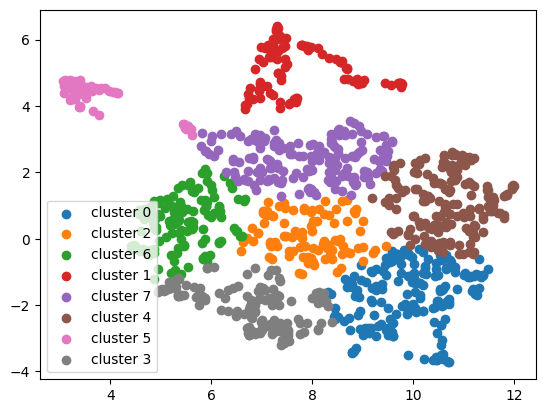

In [68]:
# n_clusters = 12
clst = KMeans()
# clst = DBSCAN(eps=0.06, min_samples=5)

labels = clst.fit_predict(embeddings_2d)
exploded_df['clst']=labels
clusters = {}
rev_lab = {}
for idx, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(idx)

for i, idxs in clusters.items():
    plt.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1], label=f'cluster {i}')
plt.legend()

In [83]:
exploded_df.groupby("track_id", as_index=False).agg({"clst": list}).set_index('track_id')['clst'].to_json(RAW_PATH('song_describer', 'openai_clustered.jsonl'))

In [1]:
exploded_df[exploded_df['clst']==4]

NameError: name 'exploded_df' is not defined

In [56]:
query_text = "relaxing piano music"
query_embedding = gpt_client.embeddings.create(input=[description], model="text-embedding-3-small").data[0].embedding
res = collection.query(
    query_embeddings=[query_embedding],
    n_results=3
)
res

{'ids': [['7eec0781-a711-41a4-b59f-6613feecd012',
   'f833a038-bf2d-4564-816d-add6e2b4a473',
   '959a83f1-837d-43f7-b132-95447c88711e']],
 'embeddings': None,
 'documents': [['Genre seems to be classical music and I feel cheerful and some what motivates me to do something enthusiastically',
   'Genre seems like a classical music played with piano and reminds me of a huge church in Europe where they play during daytime',
   "Genre seems like a electric music played with violin and feels like I'm about to do some challenging things, and the mood is pretty dark"]],
 'uris': None,
 'data': None,
 'metadatas': [[{'track_id': 959155},
   {'track_id': 1169729},
   {'track_id': 700217}]],
 'distances': [[9.260425031243358e-07,
   0.6825407147407532,
   0.6940768361091614]],
 'included': [<IncludeEnum.distances: 'distances'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

In [21]:
res

{'ids': [['d6b6cf90-8925-4333-8b7b-65ad69a7c42b',
   '047788d2-4f40-4875-9cfc-10ec44bc0c10',
   '87ac92bd-54e5-458a-829f-22634734e2ad']],
 'embeddings': None,
 'documents': [['Relaxing music played mostly on the piano that can be used while studying, meditating or just relaxing',
   'Calming instrumental music primarily on piano can be used for relaxing',
   'cheerful happy music played on a piano for relaxing']],
 'uris': None,
 'data': None,
 'metadatas': [[{'track_id': 344323},
   {'track_id': 1169719},
   {'track_id': 1124837}]],
 'distances': [[0.28798505663871765, 0.3113352060317993, 0.4105805456638336]],
 'included': [<IncludeEnum.distances: 'distances'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}